# Import libraries

In [54]:
import pandas as pd
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt

# Preprocess data

In [89]:
def preprocess(data):
    # Reorder samples
    reorder_samples = (list(data.index[141:142]) +
                       list(data.index[:106]) +
                       list(data.index[142:145]) +
                       list(data.index[106:141]) +
                       list(data.index[145:147]))

    data = data.reindex(reorder_samples)

    # Preprocessing: convert all values to floats
    data = data.replace("#N/A", np.nan)
    data = data.applymap(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)

    # Replace NA values with column mean
    data = data.fillna(data.mean())

    # Scale the data
    data = (data - data.mean()) / data.std()

    # Extend the dimension
    data = np.expand_dims(data.to_numpy(), axis=2)
    return data

In [90]:
# Load the data
art = pd.read_csv("../data/art.csv", sep=";", index_col=0)
port = pd.read_csv("../data/port.csv", sep=";", index_col=0)
vein = pd.read_csv("../data/vein.csv", sep=";", index_col=0)
tard = pd.read_csv("../data/tard.csv", sep=";", index_col=0)
labels = pd.read_csv("../data/label.csv", sep=";", index_col=0)

In [91]:
# Preprocess the data
art = preprocess(art)
port = preprocess(port)
vein = preprocess(vein)
tard = preprocess(tard)

In [92]:
# Create one matrix
matrice_3D = np.concatenate((art, port, vein, tard), axis=2)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Convert labels to categories
Y = le.fit_transform(labels.to_numpy().ravel())

# PARAFAC

In [107]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tensorly.decomposition import parafac
from sklearn.cross_decomposition import PLSRegression

def predict_with_rank(matrice_3D, Y, rank):

    # CP Decomposition
    weights, factors = parafac(matrice_3D, rank=rank)

    # PLS Regression
    pls = PLSRegression(n_components=rank)

    # Fit model
    pls.fit(factors[0], Y)

    # Prediction
    Y_pred = pls.predict(factors[0])
    
    return Y_pred


def to_categories(y, thresholds):

    categories = np.zeros_like(y)

    for i, threshold in enumerate(thresholds):
        categories[y > threshold] = i + 1

    return categories

def accuracy_for_thresholds(y_true, y_pred, thresholds):

    y_pred_categories = to_categories(y_pred, thresholds)
    
    return (accuracy_score(y_true, y_pred_categories), f1_score(y_true, y_pred_categories, average='weighted'))



In [108]:
def best_accuracy_for_rank(data, labels, rank):

    Y_pred = predict_with_rank(data, labels, rank)

    # Plages de seuils à tester
    threshold1_range = np.linspace(0.3, 0.7, 40)
    threshold2_range = np.linspace(1.3, 1.7, 40)

    best_thresholds_acc = None
    best_thresholds_F1 = None
    best_accuracy = -1
    best_F1 = -1

    for t1 in threshold1_range:
        for t2 in threshold2_range:
            
            current_thresholds = [round(t1, 3), round(t2, 3)]
            current_accuracy = accuracy_for_thresholds(labels, Y_pred, current_thresholds)[0]
            current_F1 = accuracy_for_thresholds(labels, Y_pred, current_thresholds)[1]

            if current_accuracy > best_accuracy:
                best_accuracy = round(current_accuracy, 3)
                best_thresholds_acc = current_thresholds

            if current_F1 > best_F1:
                best_F1 = round(current_F1, 3)
                best_thresholds_F1 = current_thresholds

    return [(best_thresholds_acc, best_accuracy), (best_thresholds_F1, best_F1)]


In [110]:
list_rank = [10, 30, 50, 70]
best_accuracies = []
best_F1 = []

for rank in list_rank:
    
    results = best_accuracy_for_rank(matrice_3D, Y, rank)   

    best_accuracies.append(results[0][1])
    best_F1.append(results[1][1])

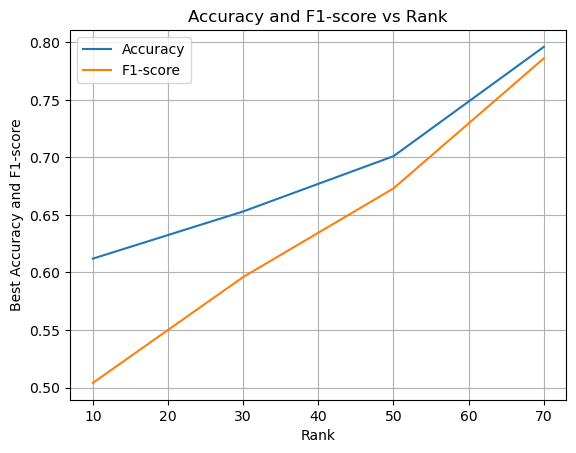

In [113]:
plt.plot(list_rank, best_accuracies, label='Accuracy')
plt.plot(list_rank, best_F1, label='F1-score')
plt.xlabel("Rank")
plt.ylabel("Best Accuracy and F1-score")
plt.title("Accuracy and F1-score vs Rank")
plt.grid()
plt.legend()
plt.show()

# Classical classifiers

## SVM

In [95]:
matrice_2D = matrice_3D.reshape(matrice_3D.shape[0], -1)
X = matrice_2D

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


# Split between train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', C=1, random_state=42)

# Fit model and predict
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

# Performances
accuracy = round(accuracy_score(Y_test, Y_pred), 2)
f1 = round(f1_score(Y_test, Y_pred, average='weighted'), 2)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Accuracy: 0.43
F1 Score: 0.48


## Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier

# Split between train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit model and predict
rf_model.fit(X_train, Y_train)
Y_pred = rf_model.predict(X_test)

# Performances
accuracy = round(accuracy_score(Y_test, Y_pred), 2)
f1 = round(f1_score(Y_test, Y_pred, average='weighted'), 2)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Accuracy: 0.53
F1 Score: 0.49
